# NLTK Naive Bayes algorithm

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split # function for splitting data to train and test sets

import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier

from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline
from subprocess import check_output

In [2]:
data = pd.read_csv('tweets_extracted.csv', encoding = 'latin-1')
# Keeping only the neccessary columns
data = data[['text','sentiment']]

First of all, splitting the dataset into a training and a testing set. The test set is the 30% of the original dataset.

In [3]:
# Splitting the dataset into train and test set
train, test = train_test_split(data,test_size = 0.3)

As a next step I separated the Positive and Negative tweets of the training set in order to easily visualize their contained words.  After that I cleaned the text from hashtags, mentions  and links. Now they were ready for a WordCloud visualization which shows only the most emphatic words of the Positive and Negative tweets.

Positive words


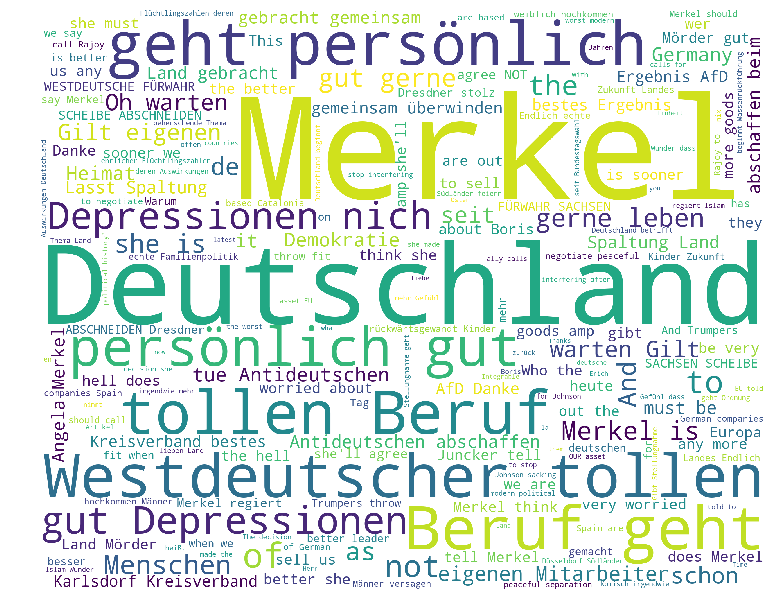

Negative words


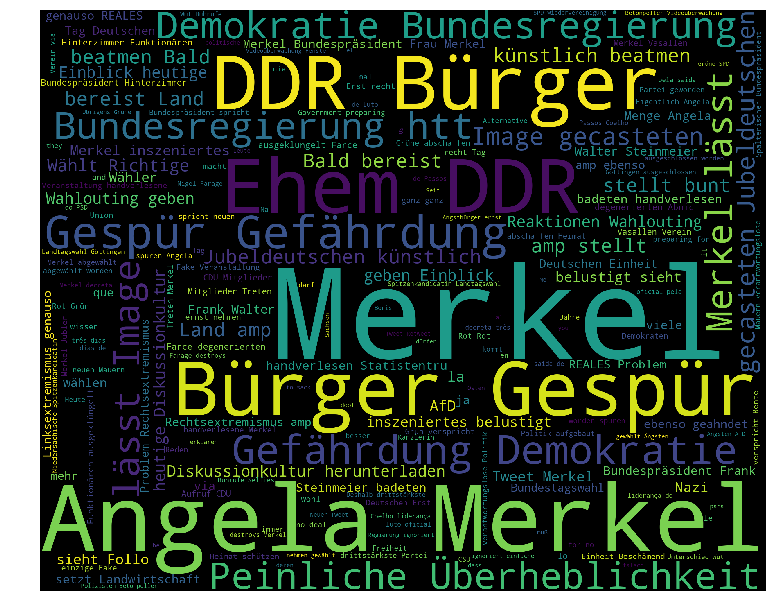

Neutral words


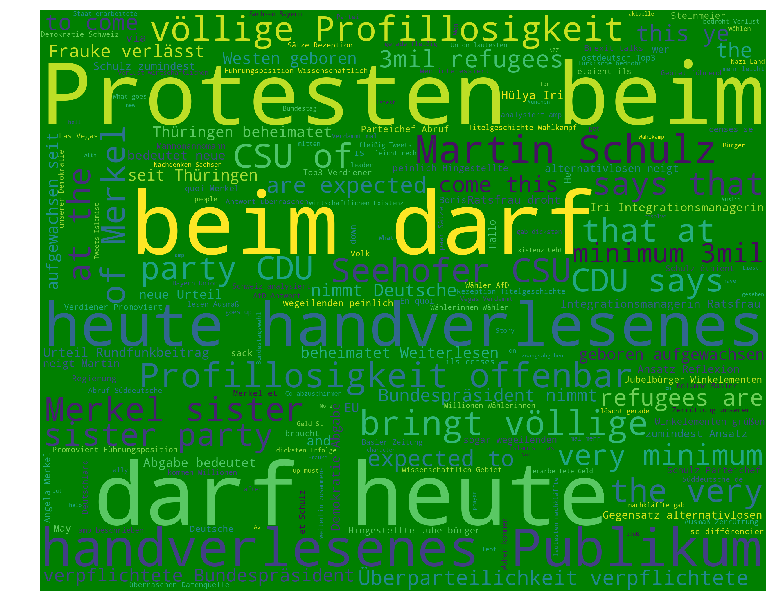

In [4]:
train_pos = train[ train['sentiment'] == 'positive']
train_pos = train_pos['text']
train_neg = train[ train['sentiment'] == 'negative']
train_neg = train_neg['text']
train_neu = train[ train['sentiment'] == 'neutral']
train_neu = train_neu['text']

def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=stopwords.words('german'),
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
print("Positive words")
wordcloud_draw(train_pos,'white')
print("Negative words")
wordcloud_draw(train_neg)
print("Neutral words")
wordcloud_draw(train_neu, 'green')

In [5]:
                
tweets = []
stopwords_set = set(stopwords.words("german"))

for index, row in train.iterrows():
    words_filtered = [e.lower() for e in row.text.split() if len(e) >= 3]
    words_cleaned = [word for word in words_filtered
        if 'http' not in word
        and not word.startswith('@')
        and not word.startswith('#')
        and word != 'RT']
    words_without_stopwords = [word for word in words_cleaned if not word in stopwords_set]
    tweets.append((words_cleaned,row.sentiment))

test_pos = test[ test['sentiment'] == 'positive']
test_pos = test_pos['text']
test_neg = test[ test['sentiment'] == 'negative']
test_neg = test_neg['text']
test_neu = test[ test['sentiment'] == 'neutral']
test_neu = test_neu['text']


As a next step I extracted the so called features with nltk lib, first by measuring a frequent distribution and by selecting the resulting keys.

In [6]:
# Extracting word features
def get_words_in_tweets(tweets):
    all = []
    for (words, sentiment) in tweets:
        all.extend(words)
    return all

def get_word_features(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    features = wordlist.keys()
    return features
w_features = get_word_features(get_words_in_tweets(tweets))

def extract_features(document):
    document_words = set(document)
    features = {}
    for word in w_features:
        features['containts(%s)' % word] = (word in document_words)
    return features

Hereby I plotted the most frequently distributed words.

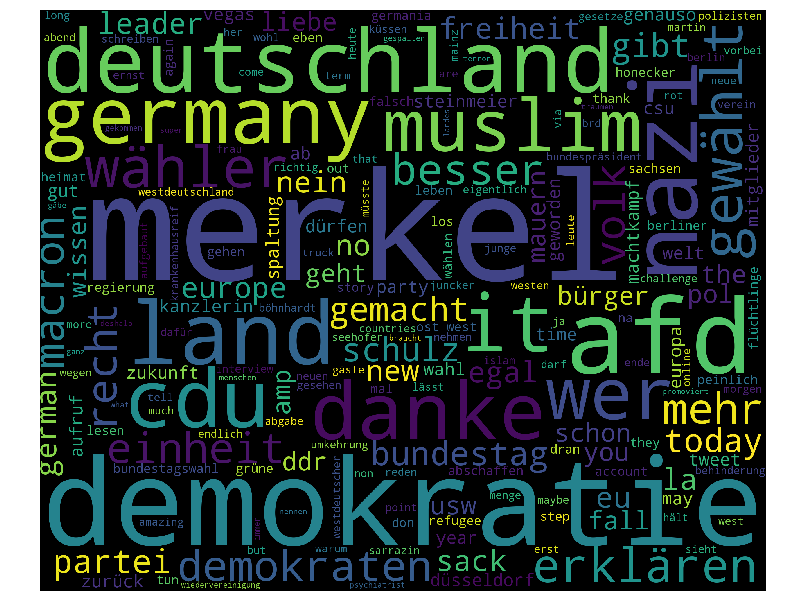

In [7]:
wordcloud_draw(w_features)

Using the nltk NaiveBayes Classifier I classified the extracted tweet word features.

In [13]:
# Training the Naive Bayes classifier
#training_set = nltk.classify.apply_features(extract_features,tweets)
#classifier = nltk.NaiveBayesClassifier.train(training_set)

In [12]:
data_set = nltk.classify.apply_features(extract_features,tweets)

train_set,test_set = train_test_split(data_set, test_size=0.7)

In [13]:
classifier_train = nltk.NaiveBayesClassifier.train(train_set)
classifier_test = nltk.NaiveBayesClassifier.train(test_set)

I tried to measure how the classifier algorithm scored.

In [14]:

neg_cnt = 0
pos_cnt = 0
neu_cnt = 0
for obj in test_neg: 
    res =  classifier_train.classify(extract_features(obj.split()))
    if(res == 'negative'): 
        neg_cnt = neg_cnt + 1
for obj in test_pos: 
    res =  classifier_train.classify(extract_features(obj.split()))
    if(res == 'positive'): 
        pos_cnt = pos_cnt + 1
for obj in test_neu: 
    res =  classifier_train.classify(extract_features(obj.split()))
    if(res == 'neutral'): 
        neu_cnt = neu_cnt + 1        
        
print('[Negative]: %s/%s '  % (len(test_neg),neg_cnt))        
print('[Positive]: %s/%s '  % (len(test_pos),pos_cnt))
print('[Neutral]: %s/%s '  % (len(test_neu),neu_cnt))

[Negative]: 640/636 
[Positive]: 132/36 
[Neutral]: 119/44 


In [24]:
print (classifier_train.show_most_informative_features(10))

Most Informative Features
         containts(beim) = True           neutra : negati =    112.9 : 1.0
         containts(geht) = True           positi : negati =     70.3 : 1.0
         containts(sehr) = True           positi : negati =     53.0 : 1.0
       containts(martin) = True           neutra : negati =     52.0 : 1.0
        containts(schon) = True           positi : negati =     49.8 : 1.0
        containts(nimmt) = True           neutra : negati =     48.4 : 1.0
         containts(neue) = True           neutra : negati =     44.8 : 1.0
          containts(gut) = True           positi : negati =     43.3 : 1.0
     containts(publikum) = True           neutra : negati =     35.3 : 1.0
         containts(this) = True           neutra : negati =     34.1 : 1.0
None


In [15]:
print(nltk.classify.accuracy(classifier_train, train_set))

0.9470304975922953


In [16]:
print(nltk.classify.accuracy(classifier_test, test_set))

0.9511691884456671
